# Quantitative Spatial Economics 

## Tutorial Topic 7: Commuting Gravity Regression

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](dominik.bursy@icloud.com), 
[Lars Felder](lars.felder@fu-berlin.de), 
[Kate Bablyak](kateryna.bablyak@student.hu-berlin.de), 
[Marlon Krippendorf](marlon.krippendorf@fu-berlin.de)


Last Update: June 2025

---

Ahlfeldt, Gabriel M., Stephen J. Redding, Daniel M. Sturm, and Nikolaus Wolf. ‘The Economics of Density: Evidence From the Berlin Wall’. Econometrica 83, no. 6 (2015): 2127–89. https://doi.org/10.3982/ECTA10876.

---

## Import Packages <a class="anchor" id="packages"></a>

In [1]:
from pathlib import Path
import os
# Traveltime x Travelcost
import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [2]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

c:\Users\lfelder\OneDrive - DIW Berlin\Spatial\qse_collaboration


---

## Estimate epsilon and kappa and recover the fundamentals

In [4]:
bezirke_file = f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/Bezirke23.shp'

# --- Load Bezirke ---
gdf_bezirke = gpd.read_file(bezirke_file).to_crs(3035)

<Axes: >

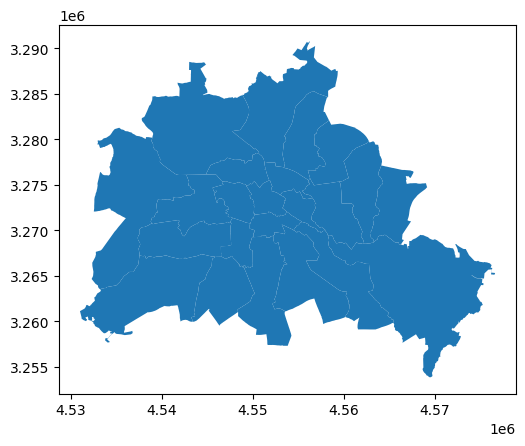

In [ ]:
gdf_bezirke.plot()
# 23 Bezirke

In [ ]:
# This file we take from the online supplementary material

df_commute = pd.read_stata(f'{ROOT_FOLDER}/data/commutebezirk_all.dta')

In [16]:
## For this we first have to run the file TT_Matrix.ipynb
# Renames the stat blocks so that we can merge TT matrix with shapefile

df_tt_matrix = pd.read_csv(f'{ROOT_FOLDER}/experiments/output/TTMATRIX_berlin_trainline.csv')
df_tt_matrix['STAT_BLOCK'] = df_tt_matrix['STAT_BLOCK'].str.replace(r'STAT_BLOCK', '', regex=True).astype(int)

In [17]:
df_tt_matrix

,STAT_BLOCK,STAT_BLOCK1001,STAT_BLOCK1005,STAT_BLOCK1007,STAT_BLOCK1009,STAT_BLOCK1010,STAT_BLOCK1012,STAT_BLOCK1013,STAT_BLOCK1044,STAT_BLOCK1072,...,STAT_BLOCK195619,STAT_BLOCK195621,STAT_BLOCK195622,STAT_BLOCK195623,STAT_BLOCK195624,STAT_BLOCK195626,STAT_BLOCK195627,STAT_BLOCK195629,STAT_BLOCK195630,STAT_BLOCK195631
0,1001,0.000000,16.362926,14.857225,15.068462,21.643129,20.112510,18.160540,23.964849,27.160806,...,77.412193,75.238834,76.541424,78.203296,79.923503,79.830944,77.347033,80.345784,74.286039,76.423457
1,1005,16.362926,0.000000,15.400846,3.129295,9.558235,21.198423,19.578184,9.783116,18.646263,...,72.202693,70.029335,71.331924,72.993796,74.714003,74.621444,72.137533,75.136284,69.076539,71.213957
2,1007,14.857225,15.400846,0.000000,14.106383,22.777888,6.421706,4.469736,23.002770,27.395990,...,76.450113,74.276755,75.579345,77.241216,78.961423,78.868864,76.384954,79.383704,73.323959,75.461378
3,1009,15.068462,3.129295,14.106383,0.000000,8.672299,19.903959,18.283721,8.897180,17.760327,...,72.366044,70.192685,71.495275,73.157147,74.877354,74.784795,72.300884,75.299635,69.239890,71.377308
4,1010,21.643129,9.558235,22.777888,8.672299,0.000000,28.575465,26.955227,4.085670,12.948817,...,72.576561,70.403203,71.705793,73.367664,75.087872,74.995312,72.511402,75.510152,69.450407,71.587826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12304,195626,79.830944,74.621444,78.868864,74.784795,74.995312,84.666441,83.046202,75.329042,68.637165,...,19.410435,15.926572,17.229162,18.891033,21.612793,0.000000,6.027789,23.377646,12.261360,14.784693
12305,195627,77.347033,72.137533,76.384954,72.300884,72.511402,82.182530,80.562292,72.845131,66.153255,...,16.926725,10.554777,11.857367,13.519238,17.481717,6.027789,0.000000,20.893936,6.233572,8.756904
12306,195629,80.345784,75.136284,79.383704,75.299635,75.510152,85.181281,83.561042,75.843882,69.152005,...,5.954233,18.525031,17.999541,17.612434,11.464087,23.377646,20.893936,0.000000,17.832941,19.970360
12307,195630,74.286039,69.076539,73.323959,69.239890,69.450407,79.121536,77.501297,69.784137,63.092260,...,13.865731,7.493782,8.796372,10.458244,14.420723,12.261360,6.233572,17.832941,0.000000,2.523332


In [ ]:
block_file = f'{ROOT_FOLDER}/resources/ARSW2015-toolkit-main/shapefile/Berlin4matlab.shp'
gdf_berlin = gpd.read_file(block_file).to_crs(3035)
# This has info on 12 Bezirke and STAT_BLOCK

In [19]:
# Merge TT Matrix with shapefile
# gdf_berlin_tt = pd.concat([gdf_berlin ,df_tt_matrix], axis=1)
gdf_berlin_tt =  gdf_berlin.merge(df_tt_matrix, on='STAT_BLOCK')

In [ ]:
# Aggregate Block level Data to the District Level
gdf_berlin_tt_T = gdf_berlin_tt[list(['BEZIRK']) + list(gdf_berlin_tt.columns[9:])].groupby('BEZIRK').mean().T
gdf_berlin_tt_T.index = gdf_berlin_tt_T.index.str.replace(r'STAT_BLOCK', '', regex=True).astype(int)
gdf_berlin_tt_T_long = pd.concat([gdf_berlin_tt_T, gdf_berlin[['BEZIRK', 'STAT_BLOCK']].set_index('STAT_BLOCK')], axis=1)
gdf_berlin_tt_T_long = gdf_berlin_tt_T_long.groupby('BEZIRK').mean()

In [ ]:
# Reshape data 
gdf_berlin_tt_T_long = pd.melt(gdf_berlin_tt_T_long.reset_index(), id_vars=['BEZIRK'])
gdf_berlin_tt_T_long.rename(columns={'BEZIRK': 'startbezirk', 'variable': 'endbezirk', 'value': 'time'}, inplace=True)

In [ ]:
# Merge data from replication repo commute survey (number of commuters as well as minutes they answered, we will use time = our TT Matrix result)

merged = pd.concat([gdf_berlin_tt_T_long, df_commute[['minutes', 'commute']]], axis=1)

In [32]:
merged

,startbezirk,endbezirk,time,minutes,commute
0,1,1,19.564730,16.190065,463.0
1,2,1,26.096926,28.193182,176.0
2,3,1,41.379910,30.253061,245.0
3,4,1,33.136895,30.561798,178.0
4,5,1,73.450638,43.869564,69.0
...,...,...,...,...,...
139,8,12,78.721560,43.250000,4.0
140,9,12,98.344931,56.666668,9.0
141,10,12,89.826495,54.285713,14.0
142,11,12,75.948318,53.250000,12.0


## Gravity Estimation

In [33]:
# Fill missing commuter data with zero (for fillin behavior)
merged["commute"] = merged["commute"].fillna(0)

# Total commuters over all Bezirke
tot_commute = merged["commute"].sum()

# Commuting probability from startbezirk to endbezirk
merged["probcomm"] = merged["commute"] / tot_commute

# Log of probability
merged["lprobcomm"] = np.log(merged["probcomm"].replace(0, np.nan))


In [34]:
merged

,startbezirk,endbezirk,time,minutes,commute,probcomm,lprobcomm
0,1,1,19.564730,16.190065,463.0,0.058254,-2.842949
1,2,1,26.096926,28.193182,176.0,0.022144,-3.810192
2,3,1,41.379910,30.253061,245.0,0.030825,-3.479417
3,4,1,33.136895,30.561798,178.0,0.022396,-3.798892
4,5,1,73.450638,43.869564,69.0,0.008681,-4.746569
...,...,...,...,...,...,...,...
139,8,12,78.721560,43.250000,4.0,0.000503,-7.594381
140,9,12,98.344931,56.666668,9.0,0.001132,-6.783451
141,10,12,89.826495,54.285713,14.0,0.001761,-6.341618
142,11,12,75.948318,53.250000,12.0,0.001510,-6.495769


In [39]:
# Generate dummy (fixed effects) variables
start_dummies = pd.get_dummies(merged["startbezirk"], prefix="sbzk")
end_dummies = pd.get_dummies(merged["endbezirk"], prefix="ebzk")

# Combine into final dataset
gravity_df = pd.concat([merged, start_dummies, end_dummies], axis=1)


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define regression variables
X_cols = ['time'] + [col for col in gravity_df.columns if col.startswith('sbzk') or col.startswith('ebzk')]
X = gravity_df[X_cols].copy()
X = X.astype(float)     # was Boolean before, statsmodels seems to not be able to automatically convert to int. 
X = sm.add_constant(X)
y = gravity_df['lprobcomm']

# OLS regression with robust standard errors
model1 = sm.OLS(y, X).fit(cov_type='HC1')  # HC1 ≈ STATA's robust
print(model1.summary())

# time          -0.0555 


                            OLS Regression Results                            
Dep. Variable:              lprobcomm   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     2539.
Date:                Thu, 12 Jun 2025   Prob (F-statistic):          1.01e-150
Time:                        17:21:11   Log-Likelihood:                -65.898
No. Observations:                 144   AIC:                             179.8
Df Residuals:                     120   BIC:                             251.1
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6755      0.131    -12.793      0.0

In [ ]:
# Repeat analysis but only with bezirke Flows of 10 or more commuters
df2 = gravity_df[gravity_df["commute"] >= 10]
X2 = df2[X_cols].copy()
X2 = X2.astype(float)
X2 = sm.add_constant(X2)
y2 = df2["lprobcomm"]

# Same OLS Reg with robust sds but subsample
model2 = sm.OLS(y2, X2).fit(cov_type='HC1')
print(model2.summary())

# Close to no change 
# time          -0.0537

                            OLS Regression Results                            
Dep. Variable:              lprobcomm   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     2921.
Date:                Thu, 12 Jun 2025   Prob (F-statistic):          4.25e-129
Time:                        17:24:19   Log-Likelihood:                -21.639
No. Observations:                 122   AIC:                             91.28
Df Residuals:                      98   BIC:                             158.6
Df Model:                          23                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7168      0.135    -12.719      0.0

In [50]:
## https://www.statsmodels.org/dev/gee.html#families

df3 = gravity_df[gravity_df["commute"] >= 10]

# GLM Poisson with robust SEs and fixed effects via categorical vars
model3 = smf.glm(
    formula="probcomm ~ time + C(startbezirk) + C(endbezirk)",
    data=df3,
    family=sm.families.Poisson(link=sm.families.links.log())
    # family=sm.families.Gaussian(link=sm.families.links.log())
).fit(cov_type='HC1')
print(model3.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               probcomm   No. Observations:                  122
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.7682
Date:                Thu, 12 Jun 2025   Deviance:                     0.059394
Time:                        17:27:31   Pearson chi2:                   0.0637
No. Iterations:                     5   Pseudo R-squ. (CS):           0.006544
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.8289 

In [51]:
model4 = smf.glm(
    formula="probcomm ~ time + C(startbezirk) + C(endbezirk)",
    data=df3,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit(cov_type='HC1')
print(model4.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               probcomm   No. Observations:                  122
Model:                            GLM   Df Residuals:                       98
Model Family:                   Gamma   Df Model:                           23
Link Function:                    log   Scale:                         0.10298
Method:                          IRLS   Log-Likelihood:                 616.90
Date:                Thu, 12 Jun 2025   Deviance:                       10.058
Time:                        17:27:38   Pearson chi2:                     10.1
No. Iterations:                    17   Pseudo R-squ. (CS):             0.9994
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1866 

---

Our Travel Time estimate for $\kappa \varepsilon$ is around 0.55

---

## References <a class="anchor" id="references"></a>

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- [https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file](#https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file)
- ...

---